In [126]:
import numpy as np
import matplotlib.pyplot as plt

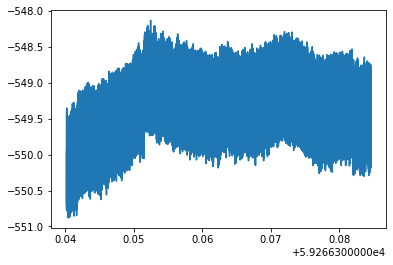

In [127]:
data = np.load('nospiketod.npy')
times = np.load('nospiketimes.npy')
plt.plot(times, data)

(0.0, 10.0)

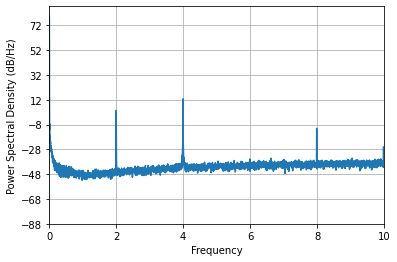

In [128]:
_,_ = plt.psd(data, NFFT=2**16, Fs=152.58)
plt.xlim([0,10])

[0]


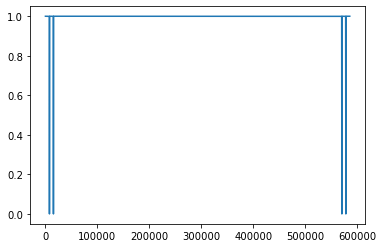

In [131]:
notch_width=0.1
spike_sigma=5
low_f=1.
beta=0.5

tod_arr = data
tod_times = times

dt = np.median(np.diff(tod_times*3600.*24.))
sample_freq = 1./dt

freqs = np.fft.fftfreq(len(tod_times), dt)

new_arr = _filter(tod_arr, tod_times)                                           
        

(0.0, 10.0)

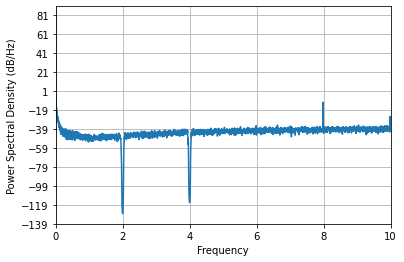

In [132]:
_,_ = plt.psd(new_arr, NFFT=2**16, Fs=sample_freq)
plt.xlim([0,10])

In [111]:
def raised_cos_notches(fs, beta, width, centers):

    vals = np.zeros_like(fs)
    T = 1 / width

    for spike in centers:
        lf = spike - (width/2)
        hf = spike + (width/2)

        fc = 0.5 * (lf + hf)

        mask_i = (fs > 0) & (np.abs(fs - fc) <= (1-beta) / (2*T))
        mask_j = (fs > 0) & ((1-beta)/(2*T) <= np.abs(fs - fc)) & (np.abs(fs - fc) <= (1+beta)/(2*T))
        mask_k = (fs < 0) & (np.abs(fs + fc) <= (1-beta) / (2*T))
        mask_l = (fs < 0) & ((1-beta)/(2*T) <= np.abs(fs + fc)) & (np.abs(fs + fc) <= (1+beta)/(2*T))

        vals[mask_i] = 1
        vals[mask_j] = 0.5*(1+np.cos((np.pi*T/beta)*(np.abs(fs[mask_j] - fc) - ((1-beta)/(2*T)))))
        vals[mask_k] = 1
        vals[mask_l] = 0.5*(1+np.cos((np.pi*T/beta)*(np.abs(fs[mask_l] + fc) - ((1-beta)/(2*T)))))

    return 1 - vals

def find_freq_spikes(freqs, tod_fft):
    above_lf = np.where(freqs >= low_f)[0]
    between_20_and_40_hz = np.where((freqs >= 20.) & (freqs <= 40.))[0]
    tod_fft_std = np.std(tod_fft[between_20_and_40_hz])
    spike_ranges = np.where(tod_fft >= spike_sigma*tod_fft_std)[0]
    
    spike_ranges_above_lf = np.asarray([i for i in spike_ranges if i in above_lf])
    
    if len(spike_ranges_above_lf) == 0:
        return None
    # Separate the spike ranges by freq
    div_i_in_ranges = np.where(np.diff(freqs[spike_ranges_above_lf]) > .01)[0]
    print(div_i_in_ranges)
    
    if len(div_i_in_ranges) == 0:
        return None
    
    separated_freq_ranges = []
    for i, ind in enumerate(div_i_in_ranges):
        if i == 0:
            sep_range = spike_ranges_above_lf[0:ind+1]
        else:
            sep_range = spike_ranges_above_lf[div_i_in_ranges[i-1]+1:ind+1]

        separated_freq_ranges.append(freqs[sep_range])

    sep_range = spike_ranges_above_lf[ind+1:]
    separated_freq_ranges.append(freqs[sep_range])

    spike_centers = np.asarray([np.mean(ran) for ran in separated_freq_ranges])

    return spike_centers

def compute_transfer_function(window, freqs, tod_fft):

    spike_freq_centers = find_freq_spikes(freqs, tod_fft)
    
    if spike_freq_centers is None:
        return np.ones_like(tod_fft)

    transfer_func = raised_cos_notches(freqs, beta, notch_width, spike_freq_centers)

    return transfer_func

def _filter(arr, times):

    tes_fft_arr = np.fft.fft(arr)

    transfer_function = compute_transfer_function('cos', freqs, tes_fft_arr)
    tes_fft_arr *= transfer_function
    plt.plot(transfer_function)
    tes_ifft_arr = np.fft.ifft(tes_fft_arr)

   

    return tes_ifft_arr.real
    




